<h1>Importing Libraries</h1>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import email
import email.policy
import tensorflow as tf
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping


<h1>Loading Data

In [2]:
easy_ham_path = '/kaggle/input/easy-ham/easy_ham/'
easy_ham_2_path = '/kaggle/input/easy-ham-2/easy_ham_2/'
spam_path = '/kaggle/input/spam-data/spam/'
spam_2_path = '/kaggle/input/spam-2/spam_2/'

In [3]:
def fetch_data(path):
    data = []
    mails = os.listdir(path)
    for mail in mails:
        f = open(path+mail, encoding = "ISO-8859-1")
        content = f.read()
        data.append(content)
        f.close()
    return data

In [4]:
easy_ham = fetch_data(easy_ham_path)
easy_ham_2 = fetch_data(easy_ham_2_path)
spam_data = fetch_data(spam_path)
spam_2 = fetch_data(spam_2_path)

In [5]:
ham = easy_ham + easy_ham_2 
spam = spam_data + spam_2

In [6]:
len(spam) + len(ham)

5800

<h1>Reformatting data into 2 columns: email and label

In [7]:
ham_d = {'email':ham,'label':[0]*len(ham)}

In [8]:
ham_df = pd.DataFrame(ham_d)
ham_df.head()

,email,label
0,From fork-admin@xent.com Mon Aug 26 15:30:57 ...,0
1,From fork-admin@xent.com Thu Sep 26 11:04:44 ...,0
2,From 0xdeadbeef-request@petting-zoo.net Tue S...,0
3,From quinlan@pathname.com Mon Sep 2 12:32:26...,0
4,From fork-admin@xent.com Mon Oct 7 21:56:36 ...,0


In [9]:
spam_d = {'email':spam,'label':[1]*len(spam)}
spam_df = pd.DataFrame(spam_d)
spam_df.head()

,email,label
0,From tba@insiq.us Fri Sep 13 13:45:55 2002\nR...,1
1,From sandir1460f46@excite.com Mon Sep 2 12:2...,1
2,From vbi@insiq.us Sat Sep 21 10:48:41 2002\nR...,1
3,From Casino-09242002-HTML@frugaljoe.330w.com ...,1
4,From spamassassin-talk-admin@lists.sourceforge...,1


<h2> Combining ham and spam data

In [10]:
frame = [ham_df,spam_df]
df = pd.concat(frame)

<h2>Shuffling Data

In [11]:
df = df.sample(frac=1,random_state = 1)

In [12]:
df.head(10)

,email,label
1822,From spamassassin-talk-admin@lists.sourceforge...,0
1998,Return-Path: marklists@mceahern.com\nDelivery-...,0
1223,From death_71@hotmail.com Mon Jun 24 17:08:51...,1
808,From rpm-list-admin@freshrpms.net Fri Oct 4 ...,0
526,From urpymoadnaogto@hotmail.com Mon Jun 24 17...,1
3672,From ilug-admin@linux.ie Thu Aug 1 17:17:28 ...,0
3375,From fork-admin@xent.com Thu Aug 22 10:47:09 ...,0
3695,From ilug-admin@linux.ie Mon Jul 22 19:49:37 ...,0
3211,From rpm-list-admin@freshrpms.net Tue Jul 30 ...,0
623,From ilug-admin@linux.ie Wed Aug 28 10:49:32 ...,0


<h2> Coverting data to csv format

In [13]:
df.to_csv("spam_assasin_dataset.csv",index=False)

In [14]:
dset = pd.read_csv('spam_assasin_dataset.csv')

In [15]:
dset.shape

(5800, 2)

In [16]:
dset.head(10)

,email,label
0,From spamassassin-talk-admin@lists.sourceforge...,0
1,Return-Path: marklists@mceahern.com\nDelivery-...,0
2,From death_71@hotmail.com Mon Jun 24 17:08:51...,1
3,From rpm-list-admin@freshrpms.net Fri Oct 4 ...,0
4,From urpymoadnaogto@hotmail.com Mon Jun 24 17...,1
5,From ilug-admin@linux.ie Thu Aug 1 17:17:28 ...,0
6,From fork-admin@xent.com Thu Aug 22 10:47:09 ...,0
7,From ilug-admin@linux.ie Mon Jul 22 19:49:37 ...,0
8,From rpm-list-admin@freshrpms.net Tue Jul 30 ...,0
9,From ilug-admin@linux.ie Wed Aug 28 10:49:32 ...,0


# **Exploratory Data Analysis**

In [17]:
dset.isnull().sum()

email    0
label    0
dtype: int64

In [18]:
dset.drop_duplicates(inplace = True)

In [19]:
dset.head(10)

,email,label
0,From spamassassin-talk-admin@lists.sourceforge...,0
1,Return-Path: marklists@mceahern.com\nDelivery-...,0
2,From death_71@hotmail.com Mon Jun 24 17:08:51...,1
3,From rpm-list-admin@freshrpms.net Fri Oct 4 ...,0
4,From urpymoadnaogto@hotmail.com Mon Jun 24 17...,1
5,From ilug-admin@linux.ie Thu Aug 1 17:17:28 ...,0
6,From fork-admin@xent.com Thu Aug 22 10:47:09 ...,0
7,From ilug-admin@linux.ie Mon Jul 22 19:49:37 ...,0
8,From rpm-list-admin@freshrpms.net Tue Jul 30 ...,0
9,From ilug-admin@linux.ie Wed Aug 28 10:49:32 ...,0


# Number of spam emails in the dataset

In [20]:
len(spam)

1898

# Number of non spam emails in the dataset

In [21]:
len(ham)

3902

# Distribution of spam and non spam emails in the dataset

<AxesSubplot:xlabel='label', ylabel='count'>

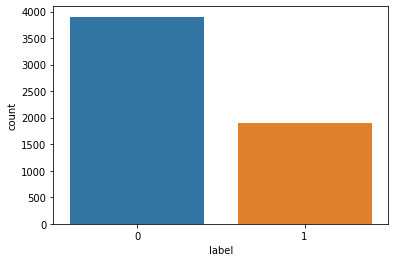

In [22]:
sns.countplot(x = 'label',data=dset)

In [23]:
print(len(ham)*100/len(dset))
print(len(spam)*100/len(dset))

67.27586206896552
32.724137931034484


<h3>About 67 percent of the data is non spam and 33 percent of the data is spam

# Parsing the emails

In [24]:
parser = email.parser.Parser(policy=email.policy.default)
emails = []
labels = []
for text, label in dset.values:
    emails.append(parser.parsestr(text))
    labels.append(label)
    


In [25]:
d = {'email':emails,'label':labels}
dataset = pd.DataFrame(d)

In [26]:
dataset.head(10)

,email,label
0,"[Return-Path, Delivered-To, Received, Received...",0
1,"[Return-Path, Delivery-Date, From, Date, Subje...",0
2,"[Return-Path, Delivery-Date, Received, Receive...",1
3,"[Return-Path, Delivered-To, Received, Received...",0
4,"[Return-Path, Delivery-Date, Received, Receive...",1
5,"[Return-Path, Delivered-To, Received, Received...",0
6,"[Return-Path, Delivered-To, Received, Received...",0
7,"[Return-Path, Delivered-To, Received, Received...",0
8,"[Return-Path, Delivered-To, Received, Received...",0
9,"[Return-Path, Delivered-To, Received, Received...",0


In [27]:
ham_type = []
spam_type = []
for email,label in dataset.values:
    if label == 0:
        ham_type.append(email.get_content_type())
    elif label == 1:
        spam_type.append(email.get_content_type())

# **Most Common types of emails**

In [28]:
type_count = Counter(ham_type)
type_count.most_common()

[('text/plain', 3753),
 ('multipart/signed', 104),
 ('multipart/alternative', 20),
 ('multipart/mixed', 16),
 ('multipart/related', 4),
 ('multipart/report', 3),
 ('text/html', 2)]

<h3> Most of the non spam emails are plain text

In [29]:
type_count = Counter(spam_type)
type_count.most_common()

[('text/plain', 817),
 ('text/html', 772),
 ('multipart/alternative', 169),
 ('multipart/mixed', 99),
 ('multipart/related', 40),
 ('text/plain charset=us-ascii', 1)]

<h3> A large number of the spam emails are containing html 

<h2> Example of email subject

In [30]:
dataset.email[1]['Subject']

'[Spambayes] spambayes package?'

# **Extracting text from emails**

In [31]:
def email_to_plain_text(email):
    for part in email.walk():
        text = str(part.get_payload())
    text = re.sub('[^ ]+\.[^ ]+','',text)
    soup = BeautifulSoup(text)
    text = soup.text.strip()
    text = re.sub('[^\w\s]+',"",text, flags = re.M)
    text = re.sub('\n',"",text)
    text = re.sub('\xa0','',text)
    text = re.sub('\w_+','',text)
    text = re.sub('\w\s?[0-9]+','',text)
    text = re.sub('[0-9]','',text)
    text = text.lower()
    return text
        

# Preprocessing Data

In [32]:
stopwords = set(STOPWORDS)
def email_to_words(emails):
    email_list =[]
    tokens = []
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    email_text = " ".join(emails)
    email_text = nltk.word_tokenize(email_text)
    for text in email_text:
        email_list.append(text)
    for word in email_list:
        if word not in stopwords:
            lemmatized =lemmatizer.lemmatize(word)
            stemmed =stemmer.stem(lemmatized)
            tokens.append(stemmed)
    token_words = " ".join(tokens)
    return token_words

In [33]:
clean_email = []
labels = []
for text,label in tqdm(dataset.values):
    plain_text = email_to_plain_text(text)
    tokenized = email_to_words([plain_text])
    clean_email.append(tokenized)
    labels.append(label)
    

100%|██████████| 5800/5800 [12:37<00:00,  7.66it/s]  


In [34]:
clean_d = {'email':clean_email,'label':labels}
clean_data = pd.DataFrame(clean_d)

In [35]:
spam_lst = list(clean_data[clean_data.label == 1].email)
ham_lst = list(clean_data[clean_data.label == 0].email)
spam_cloud_words = "".join(spam_lst)
non_spam_cloud_words = "".join(ham_lst)

<h2> Example of a spam email

In [36]:
spam_lst[1]

'athank youyour email address obtain purchas list refer wish unsubscrib list pleas enter yournam remov box previouslyunsubscrib still receiv messag may email ourabus control centeror cal write u nospa coral waymiami fl facdverdana siz web credit inc right reserv'

<h2> Example of a non spam email

In [37]:
ham_lst[4]

'dont know said measur money wrong differ ethnic group achiev atwid differ rate alway lot research doneon topic sowel among exchang popul india america generationindia look america two america look bob said valuabl resourc notin seejapan hong kong singapor im sure someon check statist number success v unsuccess defin indian immigr u statist similar number success v unsuccess scotsman im go india poor alway poor unlik countri region includ ghana nigeria et al emerg ash imperi strong growth india bless strong base valuabl'

<h2> Word Cloud for spam words

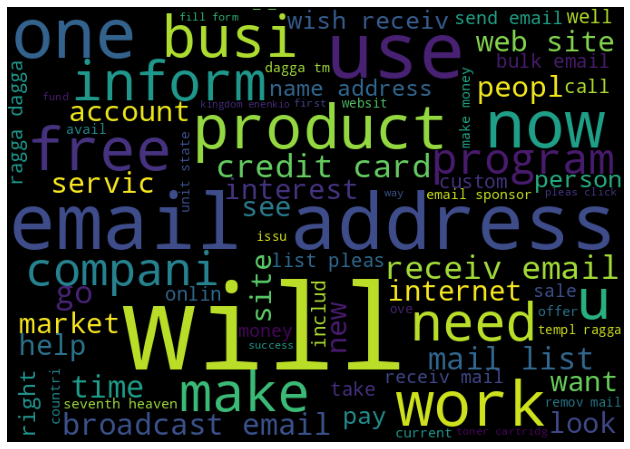

In [38]:
wordcloud = WordCloud(width=680, height=480,max_words = 75).generate(spam_cloud_words)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<h2> Word Cloud for non spam words

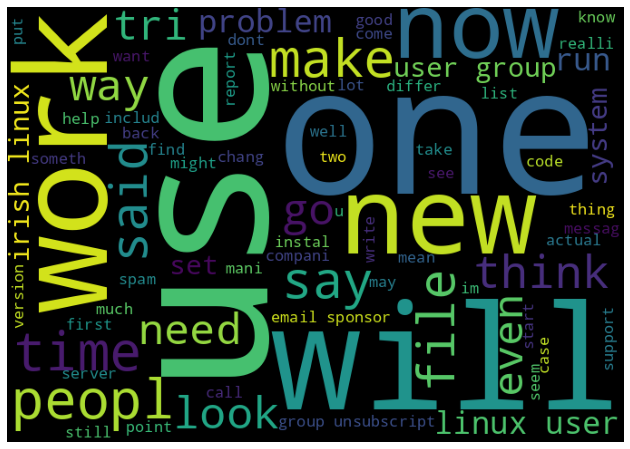

In [39]:
wordcloud = WordCloud(width=680, height=480,max_words = 75).generate(non_spam_cloud_words)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Splitting data into train and test set

In [40]:
clean_data.head(10)

,email,label
0,mo au voic made certaintytech write recent rec...,0
1,skip montanaro nasti side effect place py file...,0
2,vigor herbal sex enhancersdirect lab youw now ...,1
3,oop bad need learn mail list,0
4,athank youyour email address obtain purchas li...,1
5,local irish bore irish linux user group unsubs...,0
6,dont know said measur money wrong differ ethni...,0
7,ive got realli interest wav file friend window...,0
8,tu ju manfr grobosch wrote instal rpm tri info...,0
9,paul jakma wrote tu au david neari wrote actua...,0


In [41]:
X = clean_data['email']
y = clean_data['label']

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=1, stratify=y, test_size=0.2) 

In [43]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4640,)
(1160,)
(4640,)
(1160,)


# Vectorizing the text data

In [116]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features = 10000)
X_train_vect = vectorizer.fit_transform(X_train)
joblib.dump(vectorizer,'vectorizer.pkl')
X_test_vect = vectorizer.transform(X_test)
print(X_train_vect.shape)
print(X_test_vect.shape)

(4640, 10000)
(1160, 10000)


<h2> Standardizing the data

In [117]:
scaler = StandardScaler(with_mean=False)
X_train_std = scaler.fit_transform(X_train_vect)
joblib.dump(scaler,'scaler.pkl')
X_test_std = scaler.transform(X_test_vect)
X_train_std.shape, X_test_std.shape

((4640, 10000), (1160, 10000))

In [46]:
X_train_stand = X_train_std.toarray()
X_test_stand = X_test_std.toarray()

# Modeling and Error Analysis

<h1> Logistic Regression Implementation

<h3> Initializing weights and bias

In [47]:
def get_weights_and_bias(dimension):
    w = np.zeros(dimension)
    b = 0
    return w,b

<h3> Sigmoid function

In [48]:
def sigmoid(z):
    sig = 1/(1+np.exp(-z))
    return sig

<h3> Loss function

In [49]:
def log_loss(y_act, y_pred, alpha, w):
    y_act = np.array(y_act)
    y_pred = np.array(y_pred)
    log_loss = (-1/len(y_act))*sum(y_act*np.log10(y_pred+1e-20)+(1-y_act)*np.log10(1-y_pred+1e-20))
    l1_loss = np.sum(abs(w))
    loss = log_loss+(alpha*l1_loss)
    return loss

<h3> Gradient with respect to weights

In [50]:
def grad_dw(x, y, w, b, alpha, N):
    sigma = sigmoid(np.dot(w,x)+b)
    dw = (sigma-y)*x + (alpha/N)*((w+(1e-5))/abs(w+(1e-5)))
    return dw

<h3> Gradient with respect to bias

In [51]:
def grad_db(x, y, w, b):
    sigma = sigmoid(np.dot(w,x)+b)
    db = sigma - y
    return db

<h2> Finding optimal values for weights and bias terms on the training data using SGD

In [52]:
def train(X_tr, y_tr,alpha, lr,tolerance):
    
  train_loss=[]
  w,b = get_weights_and_bias(X_tr.shape[1])
  val = True
  epochs = 0
  while(val):
    for i in range(X_tr.shape[0]):
      dw = grad_dw(X_tr[i],y_tr[i],w,b,alpha,X_tr.shape[0])
      db = grad_db(X_tr[i],y_tr[i],w,b)
      w = w-lr*dw
      b = b-lr*db
    y_pred = []
    for x in X_tr:
      y_pred.append(sigmoid(np.dot(w,x)+b))
    loss = log_loss(y_tr,y_pred,alpha,w)
    train_loss.append(loss)
    if epochs>1:
      val = (train_loss[epochs-1]-train_loss[epochs]>=tolerance)
    epochs+=1
  return w,b,train_loss,epochs

In [53]:
w,b,loss_,epochs_ = train(X_train_stand, y_train.values,1e-4,1e-4,1e-3)

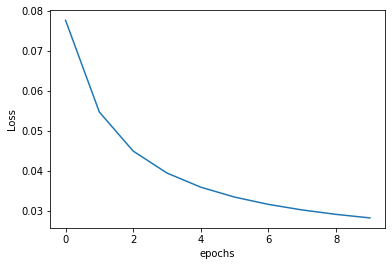

In [54]:
ep = list(range(epochs_))
plt.plot(ep,loss_)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

<h3> Predicting labels

In [55]:
def predict(X_t,w,b):
    pred = []
    for x in range(len(X_t)):
      sig = sigmoid(np.dot(w,X_t[x])+b)
      if sig>=0.5:
        pred.append(1)
      else:
        pred.append(0)
    preds= np.array(pred)
    return preds

<h2> Accuracy Metric Implementation

In [56]:
def accuracy(preds,y_t):
    correct_preds = np.sum(y_t == preds)
    total_preds = len(preds)
    acc= (correct_preds*100)/total_preds
    return acc


<h3> Train Accuracy

In [57]:
train_preds= predict(X_train_stand,w,b)
train_accuracy = accuracy(train_preds,y_train)
print(train_accuracy)

97.4353448275862


<AxesSubplot:>

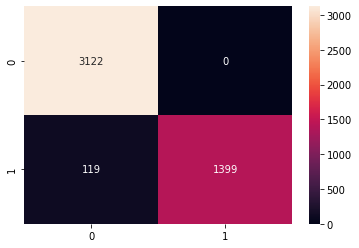

In [58]:
cm = confusion_matrix(y_train,train_preds)
sns.heatmap(cm,annot=True,fmt='d')

<h3> Test Accuracy

In [59]:
test_preds= predict(X_test_stand,w,b)
test_accuracy = accuracy(test_preds,y_test)
print(test_accuracy)

95.86206896551724


<AxesSubplot:>

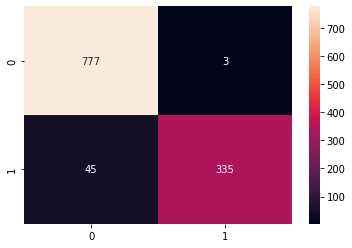

In [60]:
cm = confusion_matrix(y_test,test_preds)
sns.heatmap(cm,annot=True,fmt='d')

# Logistic Regression with cross validation

In [118]:
lgr = LogisticRegressionCV(cv=5,solver='liblinear',random_state=1,n_jobs=-1)
lgr.fit(X_train_stand,y_train)
joblib.dump(lgr,'model.pkl')

['model.pkl']

In [62]:
X_train_stand.shape

(4640, 10000)

In [63]:
lgr.predict(X_train_stand)
lg_tr_acc= lgr.score(X_train_stand,y_train)*100
print("Accuracy = ",lg_tr_acc)

Accuracy =  99.7198275862069


In [64]:
lgr.predict(X_test_stand)
lg_ts_acc = lgr.score(X_test_stand,y_test)*100
print("Accuracy = ",lg_ts_acc)

Accuracy =  98.70689655172413


<h1> Naive Bayes Model

In [65]:
nb = BernoulliNB(alpha=1)
nb.fit(X_train_std,y_train)

BernoulliNB(alpha=1)

<h3> Making predictions on train data

In [66]:
nb_train_preds = nb.predict(X_train_stand)


<h3> Train Accuracy

In [67]:
nb_tr = nb.score(X_train_stand,y_train)
print("Accuracy = {} percent".format(round(nb_tr*100)))

Accuracy = 91 percent


In [68]:
nb_test_preds = nb.predict(X_test_stand)

<h3> Test Accuracy

In [69]:
print(nb.score(X_test_stand,y_test)*100)


90.0


<h2> Hyperparameter tuning

In [70]:
rs_cv = RandomizedSearchCV(nb,{'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,10,100]},cv=10)
search = rs_cv.fit(X_train_stand,y_train)
tuned_param = search.best_params_

In [71]:
a = list(tuned_param.values())
nb = BernoulliNB(alpha=a[0])
nb.fit(X_train_std,y_train)

BernoulliNB(alpha=1e-05)

<h3> Train Accuracy after hyperparameter tuning

In [97]:
nb.predict(X_train_stand)
nb_tr_acc = (nb.score(X_train_stand,y_train)*100)
print(nb_tr_acc)

94.07327586206897


<AxesSubplot:>

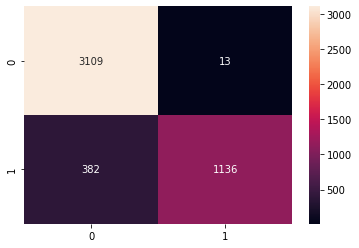

In [73]:
cm = confusion_matrix(y_train,nb_train_preds)
sns.heatmap(cm,annot=True,fmt='d')

<h3> Test accuracy after hyperparameter tuning

In [98]:
nb_test_preds = nb.predict(X_test_stand)
nb_ts_acc = (nb.score(X_test_stand,y_test)*100)
print(nb_ts_acc)

92.75862068965517


<AxesSubplot:>

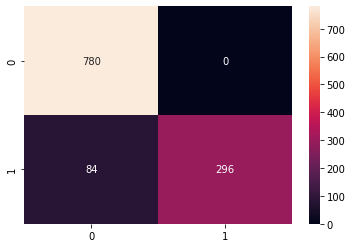

In [75]:
cm = confusion_matrix(y_test,nb_test_preds)
sns.heatmap(cm,annot=True,fmt='d')

<h2> Random Forest Classifier

In [76]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train_stand,y_train)

RandomForestClassifier(n_jobs=-1)

In [111]:
rfc_train_preds = rfc.predict(X_train_stand)
rf_tr_acc = (rfc.score(X_train_stand,y_train)*100)
print(rf_tr_acc)

99.7198275862069


<AxesSubplot:>

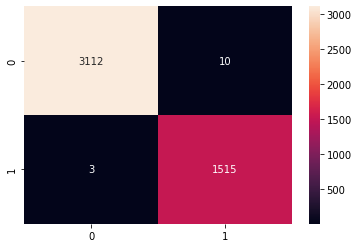

In [78]:
cm = confusion_matrix(y_train,rfc_train_preds)
sns.heatmap(cm,annot=True,fmt='d')

<h3> Test Accuracy

In [113]:
rfc_test_preds = rfc.predict(X_test_stand)
rf_ts_acc = (rfc.score(X_test_stand,y_test)*100)
print(rf_ts_acc)

97.32758620689656


<AxesSubplot:>

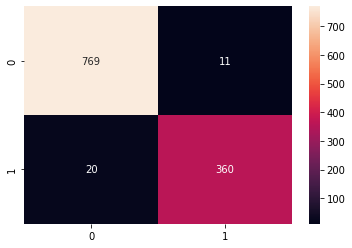

In [80]:
cm = confusion_matrix(y_test,rfc_test_preds)
sns.heatmap(cm,annot=True,fmt='d')

<h1> Advanced Machine Learning Models

<h2> Stacking Classifier

In [81]:
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42,n_jobs=-1)),
              ('nb', BernoulliNB(alpha=1e-5))]
stc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(penalty = 'l2',n_jobs=-1))
stc.fit(X_train_stand, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('nb', BernoulliNB(alpha=1e-05))],
                   final_estimator=LogisticRegression(n_jobs=-1))

<h3> Train Accuracy

In [109]:
stc_train_preds = stc.predict(X_train_stand)
stc_tr_acc = (stc.score(X_train_stand,y_train)*100)
print(stc_tr_acc)

99.52586206896552


<AxesSubplot:>

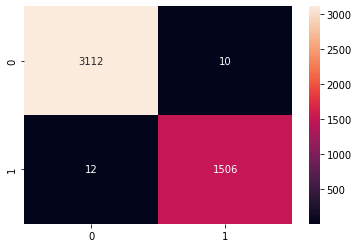

In [83]:
cm = confusion_matrix(y_train,stc_train_preds)
sns.heatmap(cm,annot=True,fmt='d')

<h3> Test Accuracy

In [110]:
stc_test_preds = stc.predict(X_test_stand)
stc_ts_acc = (stc.score(X_test_stand,y_test)*100)
print(stc_ts_acc)

97.93103448275862


<AxesSubplot:>

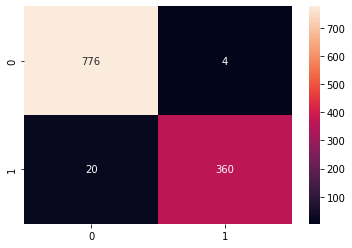

In [85]:
cm = confusion_matrix(y_test,stc_test_preds)
sns.heatmap(cm,annot=True,fmt='d')

# ****Neural Network Model****

In [99]:
snn = keras.Sequential()
snn.add(layers.Dense(16,activation= 'relu'))
snn.add(layers.Dense(12,activation= 'relu'))
snn.add(layers.Dense(1,activation='sigmoid'))

In [100]:
snn.compile(optimizer='adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
earlystop = EarlyStopping(monitor='loss',min_delta=0,patience=3,restore_best_weights=True)

In [101]:
snn.fit(X_train_stand,y_train,epochs = 100,callbacks=earlystop)
m = snn.predict(X_train_stand)

Epoch 1/100
145/145 [==============================] - 1s 2ms/step - loss: 0.2193 - accuracy: 0.8862
Epoch 2/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9700
Epoch 3/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9892
Epoch 4/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9968
Epoch 5/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9968
Epoch 6/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9970
Epoch 7/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9968
Epoch 8/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9966
Epoch 9/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9968
Epoch 10/100
145/145 [==============================] - 0s 2ms/step - loss: 0.0106 - accura

<h2> Train Accuracy

In [102]:
train_loss,nn_tr_acc = snn.evaluate(X_train_stand,y_train)

145/145 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9972


In [103]:
nn_tr_acc = nn_tr_acc*100
print("Accuracy: ",nn_tr_acc)

Accuracy:  99.71982836723328


<AxesSubplot:>

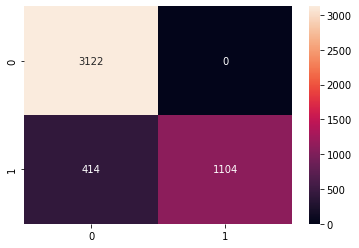

In [104]:
cm = tf.math.confusion_matrix(y_train,m)
sns.heatmap(cm,annot=True,fmt='d')

<h3> Test Accuracy

In [105]:
n= snn.predict(X_test_stand)
test_loss,nn_ts_acc = snn.evaluate(X_test_stand,y_test)

37/37 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.9724


In [106]:
nn_ts_acc = nn_ts_acc*100
print("Accuracy: ",nn_ts_acc)

Accuracy:  97.24137783050537


<AxesSubplot:>

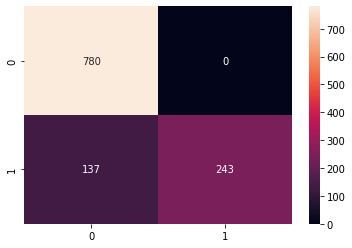

In [107]:
cm = tf.math.confusion_matrix(y_test,n)
sns.heatmap(cm,annot=True,fmt='d')


<h1> Comparing all the models

<h2> Comparing train accuracy

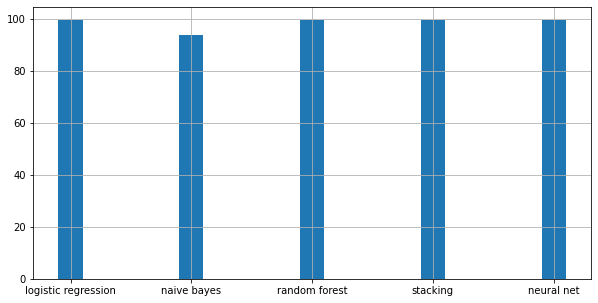

In [114]:
fig = plt.figure(figsize =(10, 5))
models = ['logistic regression','naive bayes','random forest','stacking','neural net']
results = [lg_tr_acc,nb_tr_acc,rf_tr_acc,stc_tr_acc,nn_tr_acc]
plt.bar(models,results,width = 0.2,align='center')
plt.grid()
plt.show()


<h3> Comparing test accuracy

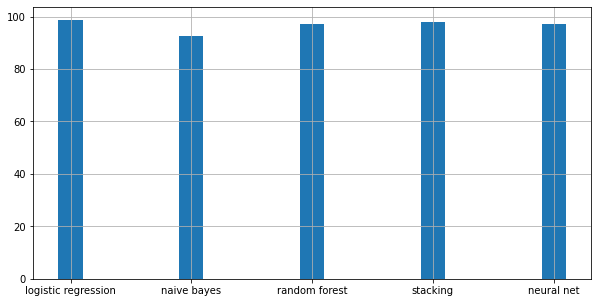

In [115]:
fig = plt.figure(figsize =(10, 5))
mod = ['logistic regression','naive bayes','random forest','stacking','neural net']
res=[lg_ts_acc,nb_ts_acc,rf_ts_acc,stc_ts_acc,nn_ts_acc]
plt.bar(mod,res,width = 0.2,align='center')
plt.grid()
plt.show()
